# MNIST Digit Generator

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import os

import torch
from torch import nn
from torch.nn import functional as F
from torchvision import datasets, transforms as T

d:\ProgramFiles\anaconda\envs\kaggle_env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_transforms = T.Compose([
  T.ToTensor(),
  T.Normalize((0.5, ), (0.5, ))
])

In [3]:
train_data = datasets.MNIST('data', train=True, download=True, transform=data_transforms)
test_data = datasets.MNIST('data', train=False, download=True, transform=data_transforms)

In [4]:
len(train_data), len(test_data)

(60000, 10000)

In [5]:
def denorm(Y, mean=0.5, std=0.5):
  """Inverse the normalisation operation. The default values for mean and std are the values used in this notebook"""
  return std * Y + mean

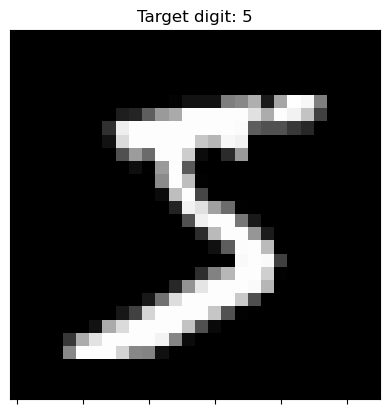

In [6]:
def plot_image(img, label=None, cmap='gray'):
  img = img.squeeze(0)
  plt.tick_params(left=False, bottom=True, labelleft=False, labelbottom=False)

  if label is not None:
    plt.title("Target digit: " + str(label))
  plt.imshow(img, cmap=cmap)


plot_image(denorm(train_data[0][0]), train_data[0][1])

In [7]:
from torch.utils.data import DataLoader

batch_size = 64
train_loader = DataLoader(train_data, batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_data, batch_size, shuffle=False, num_workers=4)

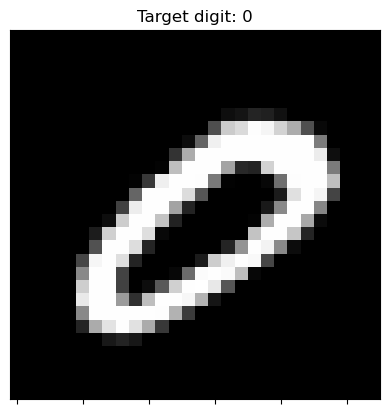

In [8]:
def check_dataloader(dloader):
  for images, labels in train_loader:
    plot_image(images[0].numpy(), labels[0].item())

    break

check_dataloader(train_loader)

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Designing the GAN

##### Desigining the Discriminator

In [10]:
class Discriminator(nn.Module):

  def __init__(self, image_size, hidden_size):
    super(Discriminator, self).__init__()

    self.image_size, self.hidden_size = image_size, hidden_size

    self.lin1 = nn.Linear(image_size, hidden_size)
    self.lrelu = nn.LeakyReLU(0.02)
    self.lin2 = nn.Linear(hidden_size, hidden_size)
    self.lin3 = nn.Linear(hidden_size, 1)
    
  def forward(self, X):
    X = self.lrelu(self.lin1(X))
    X = self.lrelu(self.lin2(X))
    return F.sigmoid(self.lin3(X))

  def __repr__(self) -> str:
    return f"Linear({self.image_size}, {self.hidden_size}) -> LeakyReLU(0.02) ->\nLinear({self.hidden_size}, {self.hidden_size}) -> LeakyReLU(0.02) ->\nLinear({self.hidden_size}, 1) -> Sigmoid()"


In [11]:
image_size, hidden_size = 784, 256
disc = Discriminator(image_size, hidden_size)
disc.to(device)

Linear(784, 256) -> LeakyReLU(0.02) ->
Linear(256, 256) -> LeakyReLU(0.02) ->
Linear(256, 1) -> Sigmoid()

##### Designing the Generator

In [18]:
class Generator(nn.Module):

  def __init__(self, latent_size, hidden_size, image_size):
    super(Generator, self).__init__()
    self.lin1 = nn.Linear(latent_size, hidden_size)
    self.lrelu = nn.LeakyReLU(0.02)

    self.lin2 = nn.Linear(hidden_size, hidden_size)
    self.lin3 = nn.Linear(hidden_size, image_size)


  def forward(self, X):
    X = self.lrelu(self.lin1(X))
    X = self.lrelu(self.lin2(X))
    return torch.tanh(self.lin3(X))

In [19]:
latent_size = 64
gen = Generator(latent_size, hidden_size, image_size)
gen.to(device)

Generator(
  (lin1): Linear(in_features=64, out_features=256, bias=True)
  (lrelu): LeakyReLU(negative_slope=0.02)
  (lin2): Linear(in_features=256, out_features=256, bias=True)
  (lin3): Linear(in_features=256, out_features=784, bias=True)
)

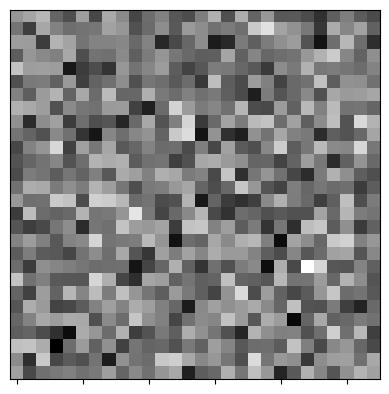

In [21]:
# testing out the generator
y = gen(torch.randn((1, latent_size), device=device))
plot_image(denorm( y.reshape(1, 28, 28).detach().cpu().numpy() ))

### Training the Discriminator

In [22]:
criterion = nn.BCELoss()
lr = 0.01

optimizers = {
  disc: torch.optim.Adam(disc.parameters(), lr=lr),
  gen: torch.optim.Adam(gen.parameters(), lr=lr)
}

In [23]:
def reset_grad(optims):
  for optim in optims:
    optim.zero_grad()

In [24]:
def get_accuracy_binary(outputs, target_class):
  """Returns num_correct"""
  len_outputs = outputs.size(0)
  num_correct = (torch.round(outputs) == target_class).sum()
  return num_correct.item()


In [25]:
a = torch.rand((3, 1))
a, get_accuracy_binary(a, 1)

(tensor([[0.9197],
         [0.8644],
         [0.6462]]),
 3)

In [26]:
def train_discriminator(images):

  # batch_size is redefined because len of images might be redefined somewhere else
  batch_size = len(images)

  real_labels = torch.ones((batch_size, 1), device=device)
  fake_labels = torch.zeros((batch_size, 1), device=device)

  # train on real data, discriminator should aim to predict 1
  outputs = disc(images)
  d_real = criterion(outputs, real_labels)
  # we set target class to 1 below, because discriminator's accuracy on real images should be based on 1
  real_score = get_accuracy_binary(outputs, 1)

  # train on fake data, discriminator should aim to predict 0
  Z = torch.randn((batch_size, latent_size), device=device)
  outputs = gen(Z)
  d_fake = criterion(outputs, fake_labels)
  # we set target class to 1 below, because discriminator's accuracy on real images should be based on 1
  fake_score = get_accuracy_binary(outputs, 0)

  d_loss = d_real + d_fake

  reset_grad(optimizers)
  d_loss.backward()

  optimizers['disc'].step()

  return d_loss, real_score, fake_score

### Generator Discriminator

In [27]:
def train_generator():
  real_labels = torch.ones((batch_size, 1), device=device)

  Z = torch.randn((batch_size, latent_size), device=device)
  fake_images = gen(Z)

  disc_preds = disc(fake_images)

  # generator has to try and fool the discriminator
  # try and make the discriminator predict 1 for actually fake images
  d_loss = criterion(disc_preds, real_labels)

  reset_grad(optimizers)
  d_loss.backward()
  optimizers['gen'].step()

##### Utilites for visualisation of images

In [28]:
real_samples_dir, fake_samples_dir = 'samples/real', 'samples/fake'

for dir in [real_samples_dir, fake_samples_dir]:
  os.makedirs(dir, exist_ok=True)

Saving above real grid of images


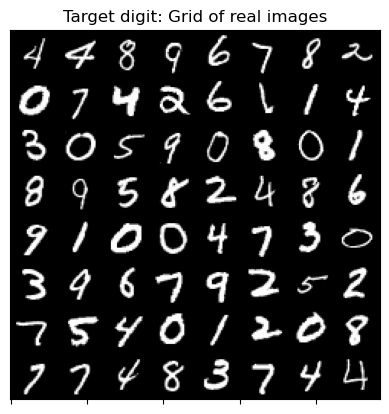

In [34]:
from IPython.display import Image
from torchvision.utils import save_image, make_grid

n_rows, n_cols = 8, 8

# we will save a grid of real images
for images, labels in train_loader:
  images = denorm(images)
  grid_image = make_grid(images, n_rows).permute(1, 2, 0)
  plot_image(grid_image, "Grid of real images")
  print("Saving above real grid of images")
  save_image(images, os.path.join(real_samples_dir, 'real_grid.png'), n_rows=n_rows)
  break